# First Attempt

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [2]:
classTrainFeatures = basic_features
classModel = 'modelSelu'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 10000
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 64, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'PRI_tau_pt', 'DER_deltar_tau_lep', 'PRI_jet_leading_eta', 'PRI_lep_eta', 'PRI_tau_eta', 'DER_lep_eta_centrality', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 'DER_pt_tot', 'DER_met_phi_centrality', 'PRI_jet_num', 'PRI_met', 'DER_pt_h', 'DER_pt_ratio_lep_tau', 'DER_sum_pt', 'PRI_jet_leading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_all_pt', 'PRI_met_sumet', 'DER_prodeta_jet_jet', 'PRI_lep_pt', 'PRI_jet_subleading_pt', 'PRI_met_phi', 'PRI_jet_leading_phi', 'PRI_lep_phi', 'PRI_jet_subleading_phi', 'PRI_tau_phi']


## Import data

In [3]:
trainData = h5py.File(dirLoc + 'train.hdf5', "r+")
valData = h5py.File(dirLoc + 'val.hdf5', "r+")

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.454s 


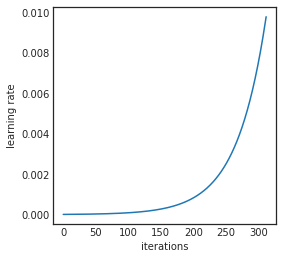

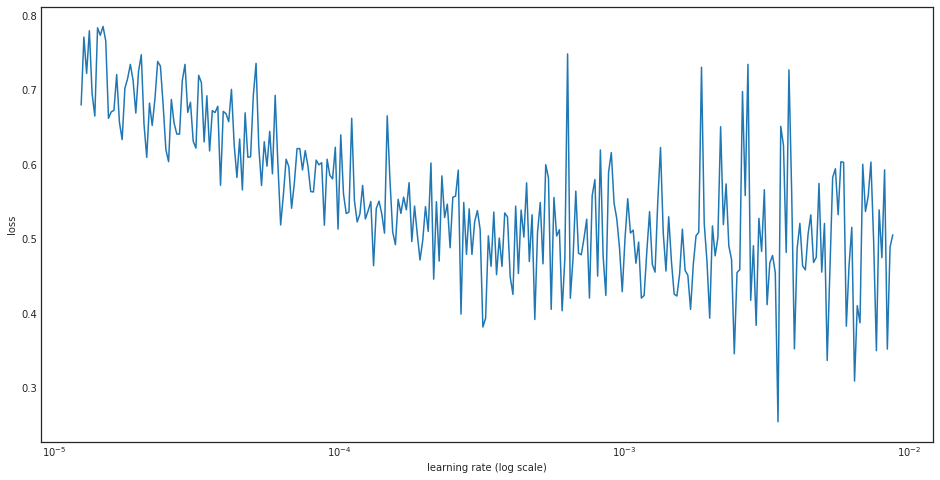

______________________________________



In [4]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-5,1e-2], trainOnWeights=False, verbose=0)

In [4]:
compileArgs['lr'] = 1e-4

## Train classifier

Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 0.503140597046
2 New best found: 0.484015078534
3 New best found: 0.472948222568
4 New best found: 0.464354984286
5 New best found: 0.45790771498
6 New best found: 0.45288987558
7 New best found: 0.447068498911
8 New best found: 0.441288785275
9 New best found: 0.43554379421
10 New best found: 0.429877827594
11 New best found: 0.424179129726
12 New best found: 0.4189199127
13 New best found: 0.414396271433
14 New best found: 0.410453855587
15 New best found: 0.406790503562
16 New best found: 0.404715273422
17 New best found: 0.401769559449
18 New best found: 0.399889682554
19 New best found: 0.397572321901
20 New best found: 0.396797347422
21 New best found: 0.395013140667
22 New best found: 0.394728934152
23 New best found: 0.392709750134
24 New best found: 0.391862455665
26 New best found: 0.390663837925
27 New best found: 0.38975963188
28 New best found: 0.388534832685
29 New best found: 0.38811860419
30 

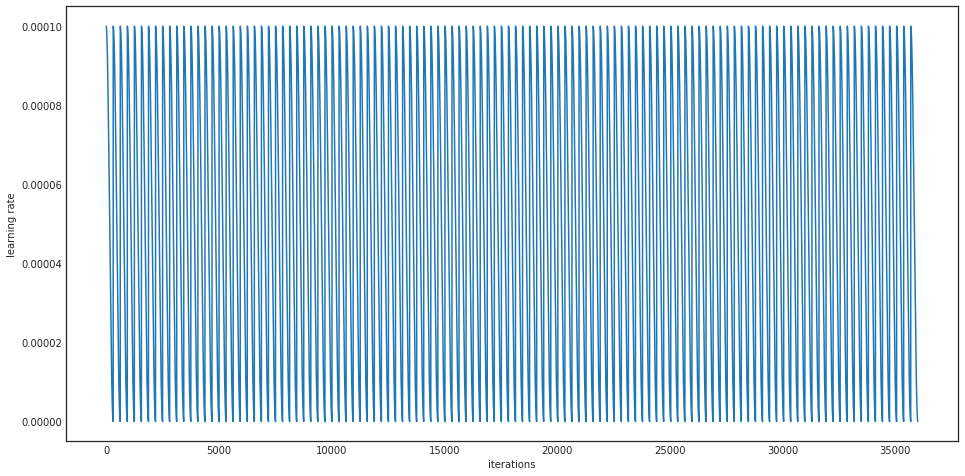

Score is: {'loss': 0.368959846402744, 'AUC': 0.09670100699518513, 'wAUC': 0.07164389853144182}
Fold took 169.130s

Running fold 2 / 10
1 New best found: 0.508189206939
2 New best found: 0.487900746177
3 New best found: 0.478732899296
4 New best found: 0.47083373208
5 New best found: 0.463930411029
6 New best found: 0.45853258907
7 New best found: 0.453385710849
8 New best found: 0.447816178648
9 New best found: 0.443862574291
10 New best found: 0.438266994338
11 New best found: 0.43434291464
12 New best found: 0.429703374855
13 New best found: 0.425502418255
14 New best found: 0.419954345446
15 New best found: 0.415207021734
16 New best found: 0.410703177593
17 New best found: 0.40718598546
18 New best found: 0.404396958752
19 New best found: 0.40132859227
20 New best found: 0.399671418124
21 New best found: 0.397461823392
22 New best found: 0.396149302403
23 New best found: 0.394478199739
24 New best found: 0.39354138907
25 New best found: 0.392663393087
26 New best found: 0.390614823

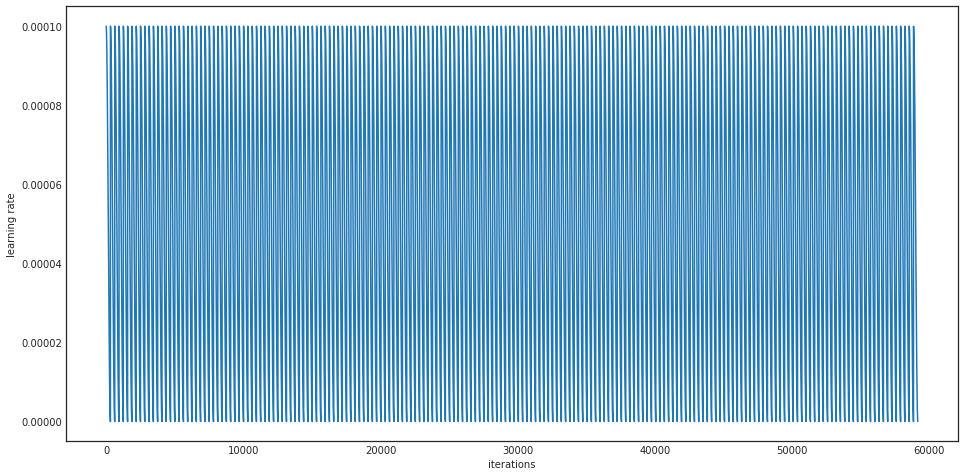

Score is: {'loss': 0.36716791847851005, 'AUC': 0.09588696099131355, 'wAUC': 0.07109137026934476}
Fold took 281.193s

Running fold 3 / 10
1 New best found: 0.500892974538
2 New best found: 0.480661968684
3 New best found: 0.470230580281
4 New best found: 0.461259333236
5 New best found: 0.455110599165
6 New best found: 0.448940877528
7 New best found: 0.443344032587
8 New best found: 0.436668304542
9 New best found: 0.43197699305
10 New best found: 0.426843710896
11 New best found: 0.421522193147


In [ ]:
results, histories = batchCosAnnealTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, trainOnWeights=False, maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on development data

In [ ]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

In [ ]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData)),
                                                            roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData), sample_weight=getFeature('weights', trainData)))

## Response on val data

In [ ]:
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', testData), getFeature('pred', testData)),
                                                           roc_auc_score(getFeature('targets', testData), getFeature('pred', testData), sample_weight=getFeature('weights', testData)))

## Evaluation

### Import in dataframe

In [ ]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'gen_sample', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['gen_weight'] = getFeature('weights', datafile, nLoad)
    data['gen_sample'] = getFeature('gen_sample', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [ ]:
devData = convertToDF(trainData)
valData = convertToDF(testData)

In [ ]:
sigVal = (valData.gen_target == 1)
bkgVal = (valData.gen_target == 0)

### ROC curve

In [ ]:
rocPlot(inData=[devData, valData],
        params=[{'linestyle':'dashed', 'color':'b'}, {'color':'b'}],
        labels=['Train', 'Test'], weightName='gen_weight')

### MVA distributions

In [ ]:
getClassPredPlot([valData[bkgVal], valData[sigVal]], weightName='gen_weight')

In [ ]:
getSamplePredPlot(valData)

## Save classified data

In [ ]:
name = dirLoc + signal + "_" + channel + "_" + varSet + '_' + classModel + '_classifiedData.csv'
print "Saving data to", name
valData.to_csv(name, columns=['gen_target', 'gen_weight', 'gen_sample', 'pred_class'])

## Save/load

In [ ]:
name = "weights/DNN_" + signal + "_" + channel + "_" + varSet + '_' + classModel
print name

### Save

In [ ]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=1)

### Load

In [ ]:
ensemble, weights, compileArgs, inputPipe, outputPipe = loadEnsemble(name)